# Example 7: Manual evaluation of non-Poissonian Likelihood

In this example we show to manually evaluate the non-Poissonian likelihood. This can be used, for example, to interface `nptfit` with parameter estimation packages other than MultiNest. We also show how to extract the prior cube.

We will take the exact same analysis as considered in the previous example, and show the likelihood peaks at exactly the same location for the normalisation of the non-Poissonian template.

**NB:** This example makes use of the Fermi Data, which needs to already be installed. See Example 1 for details.

In [1]:
# Import relevant modules

%matplotlib inline
%load_ext autoreload
%autoreload 2

import numpy as np
import healpy as hp
import matplotlib.pyplot as plt

from NPTFit import nptfit # module for performing scan
from NPTFit import create_mask as cm # module for creating the mask
from NPTFit import psf_correction as pc # module for determining the PSF correction
from NPTFit import dnds_analysis # module for analysing the output

from __future__ import print_function

## Setup an identical instance of NPTFit to Example 6

Firstly we initialize an instance of `nptfit` identical to that used in the previous example.

In [2]:
n = nptfit.NPTF(tag='non-Poissonian_Example')

In [3]:
fermi_data = np.load('fermi_data/fermidata_counts.npy').astype(np.int32)
fermi_exposure = np.load('fermi_data/fermidata_exposure.npy')
n.load_data(fermi_data, fermi_exposure)

In [4]:
analysis_mask = cm.make_mask_total(mask_ring = True, inner = 0, outer = 5, ring_b = 90, ring_l = 0)
n.load_mask(analysis_mask)

In [5]:
iso_p = np.load('fermi_data/template_iso.npy')
n.add_template(iso_p, 'iso_p')
iso_np = np.ones(len(iso_p))
n.add_template(iso_np, 'iso_np',units='PS')

In [6]:
n.add_poiss_model('iso_p','$A_\mathrm{iso}$', False, fixed=True, fixed_norm=1.51)
n.add_non_poiss_model('iso_np',
                      ['$A^\mathrm{ps}_\mathrm{iso}$','$n_1$','$n_2$','$S_b$'],
                      [[-6,1],[2.05,30],[-2,1.95]],
                      [True,False,False],
                      fixed_params = [[3,172.52]])

In [7]:
pc_inst = pc.PSFCorrection(psf_sigma_deg=0.1812)
f_ary = pc_inst.f_ary
df_rho_div_f_ary = pc_inst.df_rho_div_f_ary

Loading the psf correction from: /zfs/nrodd/CodeDev/RerunNPTFExDiffFix/psf_dir/gauss_128_0.181_10_50000_1000_0.01.npy


In [8]:
n.configure_for_scan(f_ary=f_ary, df_rho_div_f_ary=df_rho_div_f_ary, nexp=1)

The number of parameters to be fit is 3


## Evaluate the Likelihood Manually

After configuring for the scan, the instance of `nptfit.NPTF` now has an associated function `ll`. This function was passed to MultiNest in the previous example, but we can also manually evaluate it.

The log likelihood function is called as: `ll(theta)`, where `theta` is a flattened array of parameters. In the case above:

$$ \theta = \left[ \log_{10} \left( A^\mathrm{ps}_\mathrm{iso} \right), n_1, n_2 \right] $$

As an example we can evaluate it at a few points around the best fit parameters:

In [9]:
print('Vary A: ', n.ll([-4.76+0.32,18.26,0.06]), n.ll([-4.76,18.26,0.06]), n.ll([-4.76-0.37,18.26,0.06]))
print('Vary n1:', n.ll([-4.76,18.26+7.98,0.06]), n.ll([-4.76,18.26,0.06]), n.ll([-4.76,18.26-9.46,0.06]))
print('Vary n2:', n.ll([-4.76,18.26,0.06+0.93]), n.ll([-4.76,18.26,0.06]), n.ll([-4.76,18.26,0.06-1.31]))

Vary A:  -587.122352024368 -586.130196097067 -588.0937820199872
Vary n1: -586.1007629900672 -586.130196097067 -586.2930087056609
Vary n2: -587.2239543224257 -586.130196097067 -587.4195252590384


To make the point clearer we can fix $n_1$ and $n_2$ to their best fit values, and calculate a Test Statistics (TS) array as we vary $\log_{10} \left( A^\mathrm{ps}_\mathrm{iso} \right)$. As shown the likelihood is maximised at approximated where MultiNest told us was the best fit point for this parameter.

In [10]:
Avals = np.arange(-6.0,-2.0,0.01)
TSvals_A = np.array([2*(n.ll([-4.76,18.26,0.06])-n.ll([Avals[i],18.26,0.06])) for i in range(len(Avals))])

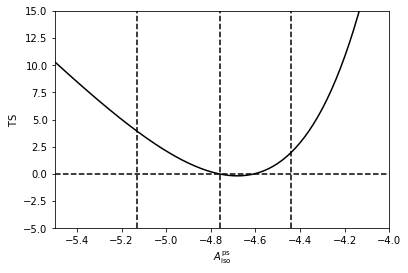

In [11]:
plt.plot(Avals,TSvals_A,color='black', lw=1.5)
plt.axvline(-4.76+0.32,ls='dashed',color='black')
plt.axvline(-4.76,ls='dashed',color='black')
plt.axvline(-4.76-0.37,ls='dashed',color='black')
plt.axhline(0,ls='dashed',color='black')
plt.xlim([-5.5,-4.0])
plt.ylim([-5.0,15.0])
plt.xlabel('$A^\mathrm{ps}_\mathrm{iso}$')
plt.ylabel('$\mathrm{TS}$')
plt.show()

Next we do the same thing for $n_2$. This time we see that this parameter is much more poorly constrained than the value of the normalisation, as the TS is very flat.

**NB:** it is important not to evaluate breaks exactly at a value of $n=1$. The reason for this is the analytic form of the likelihood involves $(n-1)^{-1}$.

In [12]:
n2vals = np.arange(-1.995,1.945,0.01)
TSvals_n2 = np.array([2*(n.ll([-4.76,18.26,0.06])-n.ll([-4.76,18.26,n2vals[i]])) for i in range(len(n2vals))])

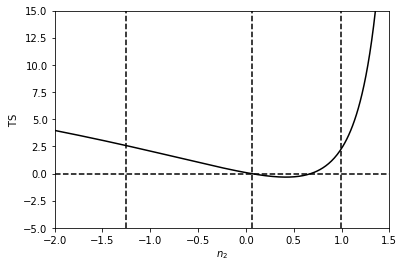

In [13]:
plt.plot(n2vals,TSvals_n2,color='black', lw=1.5)
plt.axvline(0.06+0.93,ls='dashed',color='black')
plt.axvline(0.06,ls='dashed',color='black')
plt.axvline(0.06-1.31,ls='dashed',color='black')
plt.axhline(0,ls='dashed',color='black')
plt.xlim([-2.0,1.5])
plt.ylim([-5.0,15.0])
plt.xlabel('$n_2$')
plt.ylabel('$\mathrm{TS}$')
plt.show()

In general $\theta$ will always be a flattened array of the floated parameters. Poisson parameters always occur first, in the order in which they were added (via `add_poiss_model`), following by non-Poissonian parameters in the order they were added (via `add_non_poiss_model`). To be explicit if we have $m$ Poissonian templates and $n$ non-Poissonian templates with breaks $\ell_n$, then:

$$ \theta = \left[ A_\mathrm{P}^1, \ldots, A_\mathrm{P}^m, A_\mathrm{NP}^1, n_1^1, \ldots, n_{\ell_1+1}^1, S_b^{(1)~1}, \ldots, S_b^{(\ell_1)~1}, \ldots, A_\mathrm{NP}^n, n_1^n, \ldots, n_{\ell_n+1}^n, S_b^{(1)~n}, \ldots, S_b^{(\ell_n)~n} \right]
$$

Fixed parameters are deleted from the list, and any parameter entered with a log flat prior is replaced by $\log_{10}$ of itself.

## Extract the Prior Cube Manually

To extract the prior cube, we use the internal function `log_prior_cube`. This requires two arguments: 1. `cube`, the unit cube of dimension equal to the number of floated parameters; and 2. `ndim`, the number of floated parameters.

In [14]:
print(n.prior_cube(cube=[1,1,1],ndim=3))

[1.0, 30.0, 1.9500000000000002]
